In [1]:
!pip install pdpbox

     |████████████████████████████████| 34.0 MB 37 kB/s 
     |████████████████████████████████| 13.1 MB 6.5 kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=6067fd72c8dd7606c39aee1246af155f5a86564a9c2aa57dcd16cc9589901055
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
!pip install shap

     |████████████████████████████████| 356 kB 5.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491619 sha256=5697909342fe3d40fc05031c134be54b8d0ecd8c8a4d680f0da5ef7b394ca6af
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [7]:
import pandas as pd

from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap
import seaborn as sns


def color_percent(floaty):
  "Input a normalized number between 0 and 1, and get it in string form colored according to percentage."
  if floaty >= .5:
    green = 200
    red = int(500 * (1 - floaty))
  else:
    red = 255
    green = int(400 * floaty)

  return f'\033[38;2;{red};{green};0m{floaty}\033[00m'

def numberinator(num):
    nums = '0123456789'
    numy = ''
    if type(num) == str:
        for char in num:
            if char in nums:
                numy += char

    if numy == '':
        numy = None
    else:
        numy = float(numy)

    return numy

Mean credit score 700.1159428571428
Baseline MAE 25.404601377959185
Train MAE: 7.397730285714285
Validation MAE: 19.895076333333336
R2 score: 0.385711864833544


(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f97c1d57810>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f97c2ebfc50>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


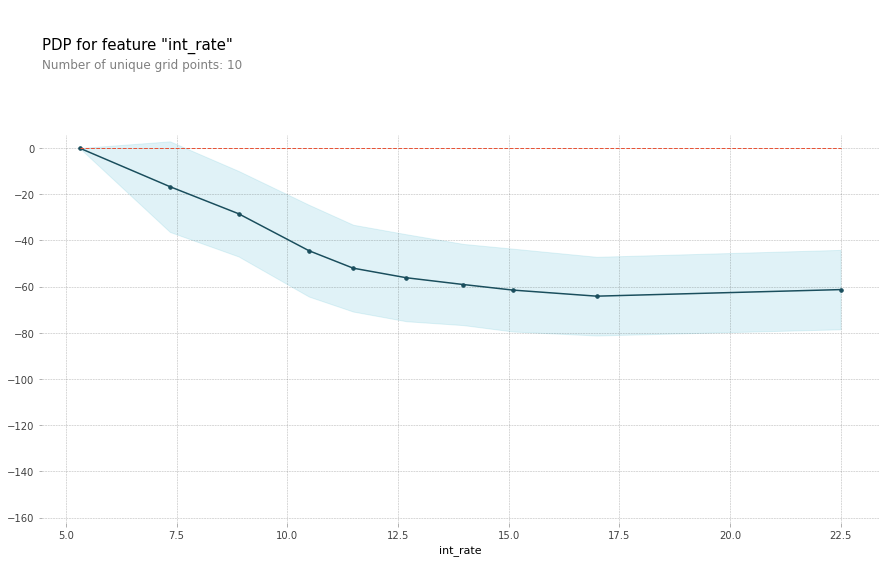

In [4]:
df = pd.read_csv('lending-club-subset.csv', skipinitialspace=True)

keep = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'annual_inc', 'inq_last_6mths', 'dti', 'open_acc', 'revol_bal', 'total_acc', 'total_pymnt_inv', 'total_rec_late_fee', 'fico_range_low', 'fico_range_high']
df = df[keep]

df['term'] = df['term'].apply(numberinator)
df['int_rate'] = df['int_rate'].str.strip('%').astype(float)
df['fico_avg'] = (df['fico_range_low'] + df['fico_range_high']) / 2
df = df.drop(columns=['fico_range_low', 'fico_range_high'])
df['dti'] = df['dti'].fillna(df['dti'].mean())


target = 'fico_avg'
X = df.drop(target, axis=1)
y = df[target]

X_train, y_train = X[:70000], y[:70000]
X_val, y_val = X[70000:85000], y[70000: 85000]
X_test, y_test = X[85000:], y[85000:]

y_pred_b1 = [y_train.mean()] * len(y_train)
print('Mean credit score', y_train.mean())
print('Baseline MAE', mean_absolute_error(y_train, y_pred_b1))

model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

print('Train MAE:', mean_absolute_error(y_train, model_rf.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_val, model_rf.predict(X_val)))
print('R2 score:', model_rf.score(X_val, y_val))


# Partial Dependence Plot
isolate = pdp_isolate(model_rf, dataset=X_val, model_features=X_val.columns, feature='int_rate')
pdp_plot(isolate, feature_name='int_rate')

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f97c2cc20d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f97c1522b10>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


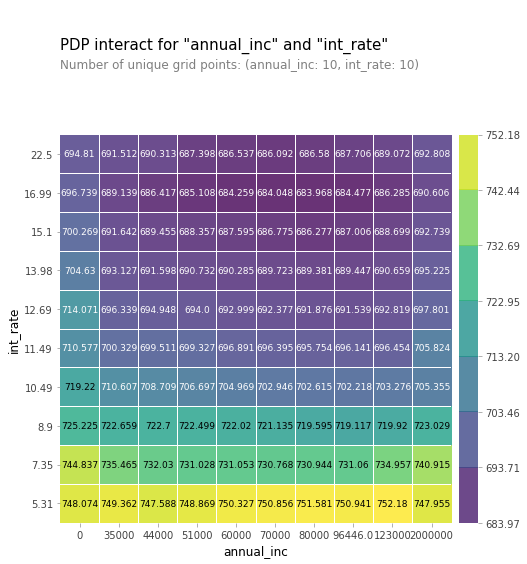

In [6]:
features = ['annual_inc', 'int_rate']
interact = pdp_interact(
    model_rf,
    dataset=X_val,
    model_features = X_val.columns,
    features = features
)
pdp_interact_plot( interact, plot_type='grid', feature_names=features)

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f97c1fdd150>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f97c2346190>})

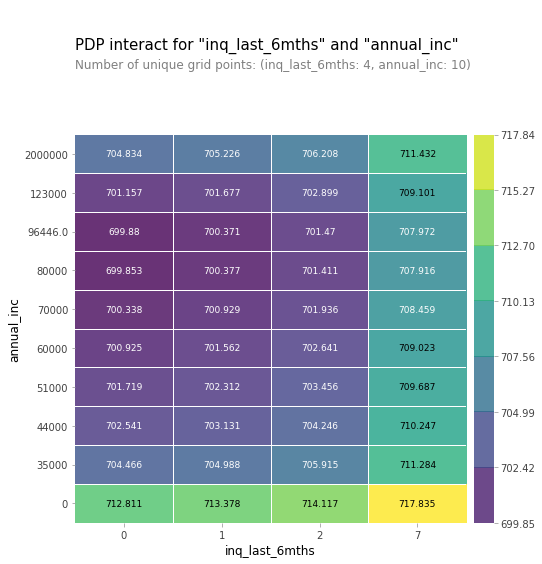

In [19]:
features = ['inq_last_6mths', 'annual_inc']
interact = pdp_interact(
    model_rf,
    dataset=X_val,
    model_features = X_val.columns,
    features = features
)
pdp_interact_plot( interact, plot_type='grid', feature_names=features)

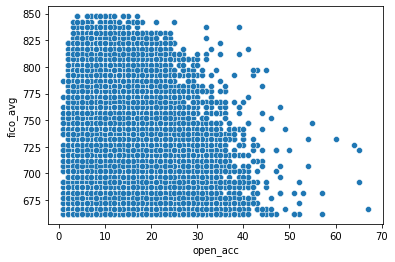

In [15]:
outlied = df[df['annual_inc'] < 200000]
sns.scatterplot(x=outlied['open_acc'], y=outlied['fico_avg'])

In [22]:
samp = X_val.head(1)

explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(samp)

shap.initjs()
shap.force_plot(base_value = explainer.expected_value,
                shap_values=shap_values,
                features=samp)